# Geometryczne - lab 4 - ćwiczenie 4

1. Przygotuj procedurę, pozwalającą wprowadzać w sposób interaktywny kolejne odcinki
(reprezentowane przez pary wierzchołków), a także generować losowo zadaną liczbę
odcinków z podanego zakresu współrzędnych 2D. Odcinki pionowe powinny być
eliminowane i żadna para odcinków nie powinna mieć końców odcinków o tej samej
współrzędnej x. Program powinien umożliwiać zapis i odczyt zbioru odcinków.
2. Zaimplementuj algorytm zamiatania sprawdzający, czy choć jedna para odcinków
w zadanym zbiorze się przecina.
3. Opisz w sprawozdaniu, jak została zaimplementowana struktura stanu (stan miotły) oraz
struktura zdarzeń w Twoim programie.
4. Uzupełnij procedurę wykrywającą przecięcie o wizualizację kolejnych kroków (pozycja
i stan miotły).
5. Przetestuj program na różnych zestawach danych.
6. Odpowiednio modyfikując program zaimplementuj algorytm wyznaczający wszystkie
przecięcia odcinków. Na wyjściu program powinien podawać liczbę wykrytych
przecięć, współrzędne przecięć oraz dla każdego przecięcia odcinki, które się
przecinają. Zmodyfikuj (jeśli to konieczne) procedurę wizualizacji dla tego zagadnienia.
7. W sprawozdaniu napisz, czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to
jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
Odpowiedź uzasadnij.
8. W sprawozdaniu krótko opisz, jak obsługiwane są zdarzenia początku odcinka, końca
odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych.
9. Przetestuj zmodyfikowany program na różnych zestawach danych.
10. Znajdź i wprowadź taki układ odcinków, przy którym pewne przecięcia będą
wykrywane więcej niż jeden raz, Czy Twój program to uwzględnia? Jeśli tak, to jak?
Napisz to w sprawozdaniu.

### Narzędzie geometryczne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

class BetterPlot:
    def __init__(self):
        self.clear()

    def clear(self):
        self.scenes = []
        self.points = []
        self.lines = []
        return self

    def add_pts(self, *pts, c='black', s=.5):
        self.points.append(PointsCollection(pts, color=c, s=s))
        return self

    def add_lines(self, *fr_to, c='black', w=.5, draw_pts=False, c_p='black', s=.5):
        self.lines.append(LinesCollection(fr_to, color=c, linewidth=w))
        if draw_pts:
            tmp_pts = []
            for ft in fr_to:
                tmp_pts.extend(ft)
            self.add_pts(*tmp_pts, c=c_p, s=s)
        return self

    def add_polygon(self, pts, close=True, draw_pts=True, c='black', c_p='black', w=.5, s=.5):
        self.add_lines(*[ [pts[i], pts[i-1]] for i in range(0 if close else 1, len(pts)) ], c=c, w=w)
        if draw_pts:
            self.add_pts(*pts, c=c_p, s=s)
        return self

    def add_scene(self, pts=None, lines=None):
        pts = [] if pts is None else pts
        lines = [] if lines is None else lines
        self.scenes.append(Scene(pts.copy(), lines.copy()))
        return self

    def save_scene_cls(self):
        self.scenes.append(Scene(self.points.copy(), self.lines.copy()))
        self.points = []
        self.lines = []
        return self

    def set_limits(self, xlim, ylim=None):
        ylim = xlim if ylim is None else ylim
        self.add_pts((xlim[0], ylim[0]), (xlim[1], ylim[1]), c='white', s=0)
        return self

    def set_uniform_scale(self, curr_xlim, curr_ylim):
        x_mid = (curr_xlim[1] + curr_xlim[0]) / 2
        x_span = curr_xlim[1] - x_mid
        y_mid = (curr_ylim[1] + curr_ylim[0]) / 2
        y_span = curr_ylim[1] - y_mid
        if y_span > x_span*1.5:
            x_span = y_span
        else:
            y_span = x_span
        self.add_pts((x_mid-x_span*1.5, y_mid-y_span), (x_mid+x_span*1.5, y_mid+y_span), c='white', s=0)
        return self

    def get_plot(self):
        if self.scenes:
            p = Plot(scenes=self.scenes)
        else:
            p = Plot(points=self.points, lines=self.lines)
        return p

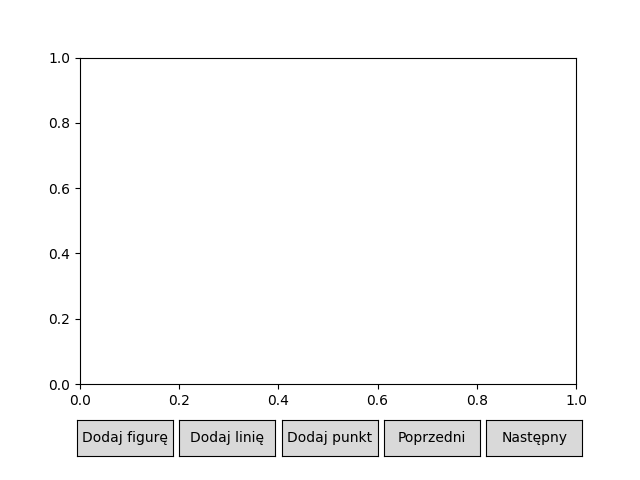

In [19]:
%matplotlib widget

p = BetterPlot().set_limits((-10, 10)).get_plot()
p.draw()

## Generowanie, zapis, odczyt odcinków

In [11]:
t = get_drawn_lines(p)
t

[[(-8.161290322580644, 6.524509803921571),
  (7.096774193548386, -5.877450980392156)],
 [(-7.141129032258065, -7.158088235294118),
  (8.383064516129034, 0.2561274509803937)],
 [(-6.120967741935484, 0.39093137254901933),
  (-4.923387096774194, -1.8333333333333321)],
 [(-3.548387096774194, -0.35049019607843235),
  (-1.862903225806452, -2.6421568627450984)],
 [(1.951612903225806, 6.052696078431374),
  (5.100806451612902, -9.045343137254903)],
 [(4.479838709677418, 6.052696078431374),
  (6.608870967741938, -9.382352941176471)]]

In [3]:
import pickle

import numpy as np


def gen_lines(xlim, ylim, amount):
    res = []
    used_x = set()
    for _ in range(amount):
        ln = [None, None]
        while ln[0] == ln[1] or ln[0][0] == ln[1][0] or ln[0][0] in used_x or ln[1][0] in used_x:
            ln = [(np.random.uniform(*xlim), np.random.uniform(*ylim)) for _ in range(2)]
        used_x.add(ln[0][0])
        used_x.add(ln[1][0])
        res.append(ln)

    return res


# odczyt z narzędzia
def get_drawn_lines(p):
    return p.get_added_lines()[0].lines


# zapis do pliku
def save_drawn_lines(p, serialise=False, save_as=None):
    lines = get_drawn_lines(p)
    if serialise:
        with open(save_as if save_as is not None else 'lines.pickle', 'wb') as f:
            pickle.dump(lines, f)
    else:
        with open(save_as if save_as is not None else 'lines.txt', 'w') as f:
            for line in lines:
                for i, (px, py) in enumerate(line):
                    f.write("(%f, %f)" % px, py)
                    if i != len(line)-1:
                        f.write(", ")
                f.write("\n")


# odczyt z pliku
def get_lines_from_file(filename=None, serialised=False):
    lines = []
    if serialised:
        with open(filename if filename is not None else 'lines.pickle', 'rb') as f:
            lines = pickle.load(f)
    else:
        with open(filename if filename is not None else 'lines.txt', 'r') as f:
            for line in f.readlines():
                if len(line) < 2:
                    continue
                line = []
                for pts_str in line.split(", ").lstrip("(").rstrip(")"):
                    p_s = pts_str.split(", ")
                    line.append((float(p_s[0]), float(p_s[1])))
                lines.append(line)

    return lines

### Definicje przykładowych zbiorów odcinków

In [12]:
test0=[[(-8.91532258064516, 5.64828431372549),
  (-4.435483870967742, 6.794117647058826)],
 [(-7.274193548387097, 3.8958333333333357),
  (1.241935483870968, 1.7389705882352935)],
 [(-10.290322580645162, 8.479166666666668),
  (8.78225806451613, 6.861519607843139)],
 [(-5.67741935483871, -1.631127450980392),
  (-5.189516129032258, 2.2107843137254903)],
 [(-1.685483870967742, 1.2671568627451002),
  (0.443548387096774, -6.5514705882352935)],
 [(1.685483870967742, -2.4399509803921564),
  (6.475806451612902, 4.7046568627451)],
 [(4.612903225806454, -0.41789215686274517),
  (6.076612903225806, -3.922794117647058)],
 [(7.895161290322582, 0.2561274509803937),
  (8.294354838709678, -3.1139705882352935)],
 [(9.758064516129034, -0.6200980392156872),
  (9.979838709677422, -2.6421568627450984)],
 [(3.770161290322582, -5.1360294117647065),
  (3.9919354838709697, -8.438725490196079)],
 [(5.01209677419355, -5.405637254901961),
  (5.36693548387097, -8.371323529411764)],
 [(8.737903225806454, -4.596813725490197),
  (9.09274193548387, -8.169117647058824)],
 [(9.358870967741938, -7.02328431372549),
  (10.689516129032258, -6.9558823529411775)]]
test1=[[(6.035298035082338, 6.555536581205249),
  (3.2479063428714667, -3.107320900470068)],
 [(-1.1261370018928591, 4.670935881888694),
  (-2.8019785893629727, 2.1852011849844537)],
 [(5.585597526348597, 5.60345801721761),
  (-9.917108160380504, -7.894633173728853)],
 [(8.762179820956284, -0.582230204913321),
  (-0.9810336347743274, 4.673781136040141)],
 [(2.757887454855334, 2.446302430919591),
  (-0.8416707028503101, -1.3529756640059816)],
 [(8.599884781078533, -3.568294301207125),
  (-6.516541281732204, 4.554971069198865)],
 [(-4.819476551178052, -2.563715775798432),
  (1.6662154183908395, -0.7912566071552245)],
 [(1.7036437064649697, -4.250480131612333),
  (8.864479829676107, 3.3567033270565094)],
 [(4.067851310090926, -8.26397641133754),
  (-8.457168257970352, -6.3690873014286336)],
 [(-5.830215492544452, -6.016940785036155),
  (9.397981485183028, -3.380074396358374)],
 [(-2.0710903713218576, 5.188550799291269),
  (2.2226324923978034, 5.935229564317062)],
 [(-0.7868835115796067, 3.5450419370540605),
  (-9.702165051699396, -4.837564620730703)],
 [(0.3366945870105713, -9.803076586600522),
  (4.706856874724533, 2.1026633209751378)],
 [(7.096081182263983, 6.27737926257587),
  (6.7392611895069905, 5.377650584268732)],
 [(3.518979817742661, -6.272836166195144),
  (5.8265548592144984, -2.5071006479005415)],
 [(-2.7792682554956505, -8.599392491385426),
  (8.651714781650448, -5.581069436391992)],
 [(-3.3166723070991093, 5.3678032759489565),
  (1.9200399481100643, -4.298812848047566)],
 [(-8.643263360952895, -3.5440235111265856),
  (2.4819988023758306, -7.61328905573416)],
 [(-8.291625105875307, 4.169126294031498),
  (-5.123082841373687, -4.598284361190754)],
 [(-2.5689799725797435, 7.353026935680052),
  (5.519367662115862, -3.3332432236357974)]]
test2=[[(-7.318548387096774, 7.535539215686278),
  (5.67741935483871, -3.653186274509803)],
 [(-8.870967741935484, -6.349264705882353),
  (7.096774193548386, 1.8063725490196099)],
 [(-6.165322580645162, 0.18872549019608087),
  (-4.745967741935484, 1.8063725490196099)],
 [(-3.637096774193548, 0.4583333333333357),
  (-1.064516129032258, -0.283088235294116)]]
test3=[[(-6.564516129032258, 4.300245098039216),
  (6.608870967741938, -5.1360294117647065)],
 [(-4.125, -3.5857843137254903), (5.899193548387098, 1.6715686274509807)],
 [(-5.633064516129032, 0.7953431372549034),
  (5.36693548387097, 0.6605392156862742)]]
test4=[[(-8.028225806451612, 4.569852941176471),
  (8.07258064516129, -7.090686274509805)],
 [(-7.983870967741936, 0.5931372549019613),
  (8.250000000000002, -0.013480392156861143)],
 [(-6.34274193548387, -3.7879901960784306),
  (7.229838709677422, 2.884803921568629)],
 [(-3.237903225806452, -7.629901960784315),
  (0.044354838709677935, 5.24387254901961)]]
test5=[[(-8.161290322580644, 6.524509803921571),
  (7.096774193548386, -5.877450980392156)],
 [(-7.141129032258065, -7.158088235294118),
  (8.383064516129034, 0.2561274509803937)],
 [(-6.120967741935484, 0.39093137254901933),
  (-4.923387096774194, -1.8333333333333321)],
 [(-3.548387096774194, -0.35049019607843235),
  (-1.862903225806452, -2.6421568627450984)],
 [(1.951612903225806, 6.052696078431374),
  (5.100806451612902, -9.045343137254903)],
 [(4.479838709677418, 6.052696078431374),
  (6.608870967741938, -9.382352941176471)]]

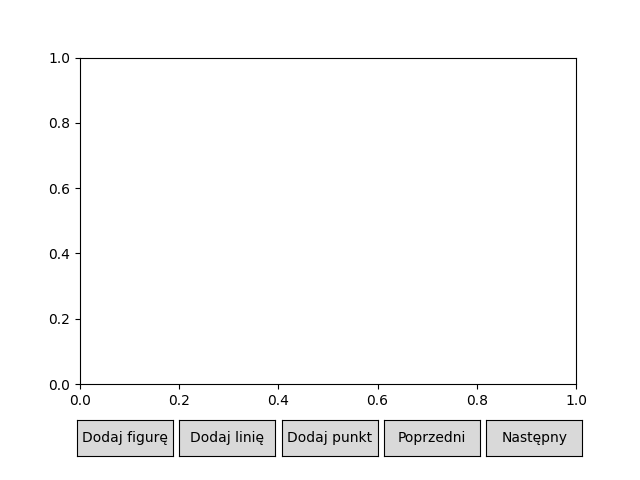

In [5]:
# wizualizacja
p = BetterPlot().set_limits((-10, 10)).add_lines(*test0, draw_pts=True, s=10).get_plot()
p.draw()

## Wykrywanie jakiegokolwiek przecięcia

In [6]:
from enum import Enum

from bintrees import RBTree

class EventType(Enum):
    START = 0,
    END = 1,
    INTERSECT = 2


def getyoflineatgivenx(line, x):
    p1, p2 = line
    x_a, y_a = p1
    x_b, y_b = p2
    return (y_a-y_b)/(x_a-x_b)*x + (y_a-(y_a-y_b)/(x_a-x_b)*x_a)


def getintersect(line1, line2, eps=10**(-12)):
    p1, p2 = line1
    p3, p4 = line2
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    l1 = lambda s: (x1+s*(x2-x1), y1+s*(y2-y1))
    # l2 = lambda t: (x3+t*(x4-x3), y3+t*(y4-y3))
    # s = lambda t: (x3-x1+t*(x4-x3))/(x2-x1)
    # t0 = (y1-y3+((x3-x1+t*(x4-x3))/(x2-x1))*(y2-y1))/(y4-y3)
    a1, b1, c1 = x2-x1, x3-x4, x3-x1
    a2, b2, c2 = y2-y1, y3-y4, y3-y1
    denominator = a1*b2-a2*b1
    if abs(denominator) < eps:
        return None
    trues = (c1*b2-c2*b1)/denominator
    truet = (a1*c2-a2*c1)/denominator
    return l1(trues) if 0 <= trues <= 1 and 0 <= truet <= 1 else None


def sweeping_any_intersects(lines, vis_data, foundisect):
    def handle_intersect(lind1, lind2):
        t = getintersect(getln1(lind1), getln1(lind2))
        if t is not None:
            foundisect.append(t)
            return True

    N = len(lines)
    getli = lambda i: i%N
    getpi = lambda i: i//N
    getln = lambda i: lines[getli(i)]
    getln1 = lambda lni: lines[lni]
    getpt = lambda i: getln(i)[getpi(i)]
    getxc = lambda i: getpt(i)[0]
    getxc1 = lambda tpl: getxc(tpl[0])
    getyc = lambda i: getpt(i)[1]
    getother = lambda i: getln(i)[1-getpi(i)]
    isend = lambda i: getxc(i) > getother(i)[0]

    getevtype = lambda line, ind: EventType.START if line[ind][0] < line[1-ind][0] else EventType.END
    where_left = [0 if getevtype(line, 0) == EventType.START else 1 for line in lines]
    keys = [lines[i][where_left[i]][1] for i, _ in enumerate(lines)]

    events = sorted(((i, EventType.END if isend(i) else EventType.START) for i in range(N*2)), key=getxc1)
    state = RBTree()
    for evind, evtype in events:
        evx = getxc(evind)
        vis_data.append({'evpt': getpt(evind), 'state': set(state.values())})
        updstate = []
        for v in state.values():
            k = getyoflineatgivenx(lines[v], evx)
            updstate.append((k, v))
            keys[v] = k
        state.clear()
        state.update(updstate)

        evyc, evlind = getyc(evind), getli(evind)
        if evtype == EventType.START:
            state.insert(evyc, evlind)
            try:
                if handle_intersect(state.succ_item(evyc)[1], evlind):
                    return True
            except KeyError: pass
            try:
                if handle_intersect(state.prev_item(evyc)[1], evlind):
                    return True
            except KeyError: pass
        elif evtype == EventType.END:
            try:
                if handle_intersect(state.succ_item(evyc)[1], state.prev_item(evyc)[1]):
                    return True
            except KeyError: pass
            try:
                state.pop(keys[evlind])
            # fallback - nigdy się nie powinno zdarzyć
            except KeyError:
                for k, v in state.items():
                    if v == evlind:
                        state.pop(k)
                        break
    return False


def draw_any_intersects(lines):
    vis_data = []
    foundisect = []
    rv = sweeping_any_intersects(lines, vis_data, foundisect)
    b = BetterPlot()
    for step_data in vis_data:
        evpt = step_data['evpt']
        b.set_limits((-10, 10)).add_lines(*lines, draw_pts=True, s=10)
        b.add_lines(*(lines[i] for i in step_data['state']), draw_pts=False, c='blue')
        b.add_lines(((evpt[0], -10), (evpt[0], 10)), c='red', draw_pts=False)
        b.add_pts(evpt, c='red', s=10).save_scene_cls()
    if rv:
        b.set_limits((-10, 10)).add_lines(*lines, draw_pts=True, s=10)
        b.add_pts(foundisect[0], c='cyan', s=10).save_scene_cls()
    return b.get_plot()

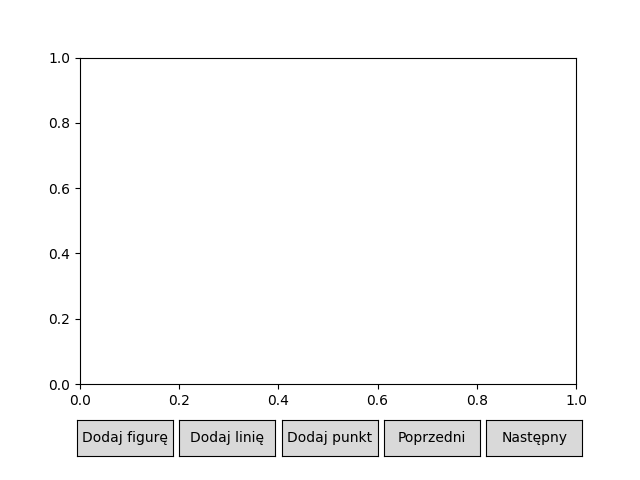

In [7]:
# Wizualizacja
p = draw_any_intersects(test0)
p.draw()

## Wykrywanie wszystkich przecięć

In [16]:
def sweeping_all_intersects(lines, vis_data):
    def handle_isect_if_present(lind1, lind2, x):
        intersect = getintersect(lines[lind1], lines[lind2])
        if intersect is not None:
            id = getuniqintid(lind1, lind2)
            if id not in detected_intersects:
                detected_intersects.add(id)
                rv.append((intersect, id))
            if Q.get(intersect[0]) is None and x < intersect[0]:
                Q.insert(intersect[0], (EventType.INTERSECT, lind1, lind2))

    rv = []
    detected_intersects = set()
    getuniqintid = lambda lind1, lind2: (min(lind1, lind2), max(lind1, lind2))
    getevtype = lambda line, ind: EventType.START if line[ind][0] < line[1-ind][0] else EventType.END

    where_left = [0 if getevtype(line, 0) == EventType.START else 1 for line in lines]
    keys = [lines[i][where_left[i]][1] for i, _ in enumerate(lines)]

    Q = RBTree()
    for i, line in enumerate(lines):
        Q.insert(line[0][0], (getevtype(line, 0), i, None))
        Q.insert(line[1][0], (getevtype(line, 1), i, None))

    T = RBTree()
    while not Q.is_empty():
        broom_x, (event_type, line_index1, line_index2) = Q.pop_min()
        vis_data.append({'evpt': (broom_x, getyoflineatgivenx(lines[line_index1], broom_x)) if line_index2 is None
                                 else getintersect(lines[line_index1], lines[line_index2]),
                         'state': set(T.values()), 'isects': [pt for pt, _ in rv]})

        if event_type != EventType.INTERSECT:
            updstate = []
            for v in T.values():
                k = getyoflineatgivenx(lines[v], broom_x)
                updstate.append((k, v))
                keys[v] = k
            T.clear()
            T.update(updstate)

        key = keys[line_index1]
        if event_type == EventType.START:
            T.insert(key, line_index1)
            try: handle_isect_if_present(T.succ_item(key)[1], line_index1, broom_x)
            except KeyError: pass
            try: handle_isect_if_present(line_index1, T.prev_item(key)[1], broom_x)
            except KeyError: pass

        elif event_type == EventType.END:
            try: handle_isect_if_present(T.succ_item(key)[1], T.prev_item(key)[1], broom_x)
            except KeyError: pass
            T.pop(key)

        elif event_type == EventType.INTERSECT:
            key1, key2 = keys[line_index1], keys[line_index2]
            val1, val2 = T.pop(key1), T.pop(key2)
            T.insert(key1, val2)
            T.insert(key2, val1)
            keys[line_index1], keys[line_index2] = keys[line_index2], keys[line_index1]

            try: handle_isect_if_present(T.succ_item(key1)[1], line_index2, broom_x)
            except KeyError: pass
            try: handle_isect_if_present(line_index1, T.prev_item(key2)[1], broom_x)
            except KeyError: pass

    return len(rv), rv


def draw_all_intersects(lines):
    vis_data = []
    amount, rv = sweeping_all_intersects(lines, vis_data)
    print(amount)
    b = BetterPlot()
    for step_data in vis_data:
        evpt = step_data['evpt']
        b.set_limits((-10, 10)).add_lines(*lines, draw_pts=True, s=10)
        b.add_lines(*(lines[i] for i in step_data['state']), draw_pts=False, c='blue', w=1)
        b.add_lines(((evpt[0], -10), (evpt[0], 10)), c='red', draw_pts=False)
        b.add_pts(*step_data['isects'], c='cyan', s=10)
        b.add_pts(evpt, c='red', s=10).save_scene_cls()
    b.set_limits((-10, 10)).add_lines(*lines, draw_pts=True, s=10)
    b.add_pts(*(pt for pt, _ in rv), c='cyan', s=10).save_scene_cls()
    return b.get_plot()

30


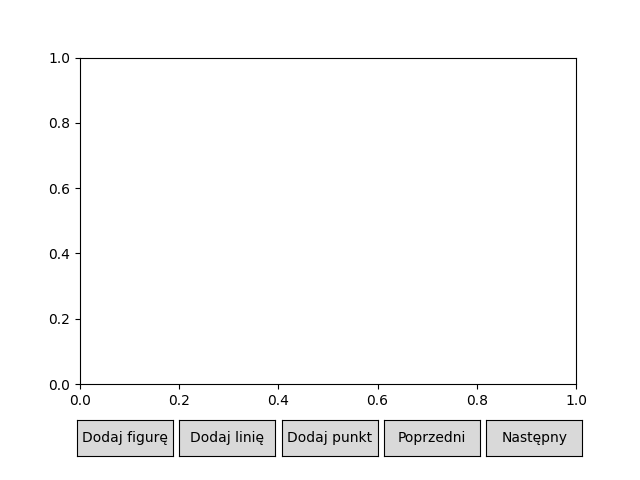

In [32]:
# Wizualizacja
p = draw_all_intersects(gen_lines((-10, 10), (-10, 10), 20))
p.draw()